In [42]:



import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from keras import callbacks

In [7]:
data  = pd.read_csv('BrainStructures_data.csv')

In [8]:
features = data.iloc[:,191:390] #all columns related to volume, size or thickness of an area of the brain
response = data[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] #Big Five Personality Types

df = pd.merge(features, response, how = 'inner', left_index = True, right_index = True)

In [9]:
features.isnull().sum()

FS_IntraCranial_Vol             93
FS_BrainSeg_Vol                 93
FS_BrainSeg_Vol_No_Vent         93
FS_BrainSeg_Vol_No_Vent_Surf    93
FS_LCort_GM_Vol                 93
                                ..
FS_R_Supramarginal_Area         93
FS_R_Frontalpole_Area           93
FS_R_Temporalpole_Area          93
FS_R_Transversetemporal_Area    93
FS_R_Insula_Area                93
Length: 199, dtype: int64

## <span style = 'color: DodgerBlue'> Exploratory Analysis & Preprocessing

In [10]:
df.shape,   df.select_dtypes('float64').shape

((1206, 204), (1206, 204))

In [11]:
df[df.isna().any(axis = 1)].head(5)

,FS_IntraCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,FS_SubCort_GM_Vol,FS_Total_GM_Vol,FS_SupraTentorial_Vol,...,FS_R_Supramarginal_Area,FS_R_Frontalpole_Area,FS_R_Temporalpole_Area,FS_R_Transversetemporal_Area,FS_R_Insula_Area,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,27.0,15.0,28.0,24.0,25.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,37.0,34.0,15.0,28.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,33.0,17.0,37.0,21.0,31.0
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.0,18.0,27.0,18.0,26.0
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,24.0,47.0,12.0,33.0


In [12]:
df1 = df.dropna()
df1.shape

(1106, 204)

array([[<AxesSubplot:title={'center':'FS_BrainSeg_Vol_No_Vent_Surf'}>,
        <AxesSubplot:title={'center':'FS_LCort_GM_Vol'}>],
       [<AxesSubplot:title={'center':'FS_RCort_GM_Vol'}>,
        <AxesSubplot:title={'center':'FS_TotCort_GM_Vol'}>],
       [<AxesSubplot:title={'center':'FS_R_Transversetemporal_Area'}>,
        <AxesSubplot:title={'center':'NEOFAC_O'}>]], dtype=object)

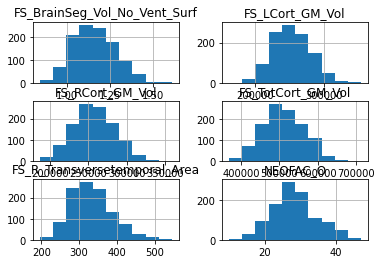

In [13]:
#spot check distribution, nothing out of the ordinary
df1[['FS_BrainSeg_Vol_No_Vent_Surf', 'FS_LCort_GM_Vol', 'FS_RCort_GM_Vol', 'FS_TotCort_GM_Vol', 'FS_R_Transversetemporal_Area', 'NEOFAC_O']].hist()


<AxesSubplot:>

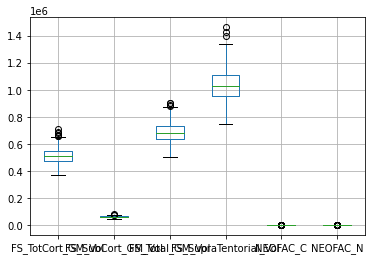

In [14]:
#spot check for outliers, nothing out of the ordinary
df1[['FS_TotCort_GM_Vol', 'FS_SubCort_GM_Vol', 'FS_Total_GM_Vol','FS_SupraTentorial_Vol', 'NEOFAC_C', 'NEOFAC_N']].boxplot()

In [15]:
X = df1.drop(['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E'], axis = 1)
y = df1[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]

In [16]:
scaler  =  StandardScaler()
preprocessor = ColumnTransformer(transformers =[('scaler', scaler, list(X.columns))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

## <span style = 'color: DodgerBlue'> Machine Learning

In [17]:
linear = LinearRegression()

paramaters = {'linear_label__fit_intercept': [True, False]}

linear_model = Pipeline([
    ('preprocessor_label', preprocessor),
    ('linear_label', linear)
])


linear_gs = GridSearchCV(linear_model, param_grid = paramaters )
linear_score = linear_gs.fit(X_train, y_train).score(X_test, y_test)
linear_y_pred = linear_gs.predict(X_test)
linear_mae = mean_absolute_error(y_test, linear_y_pred ) 
linear_mse = mean_squared_error(y_test, linear_y_pred ) 
f'score: {linear_score},  mae: {linear_mae},  mse: {linear_mse} '



'score: -0.22749538503812677,  mae: 5.62000231034196,  mse: 49.28958794363371 '

In [18]:
knn = KNeighborsRegressor()
paramaters = {'knn_label__weights': ['distance', 'uniform'], 'knn_label__n_neighbors': [2,5,7 ]}

knn_model = Pipeline([
    ('preprocessor_label', preprocessor),
    ('knn_label', knn)
])


knn_gs = GridSearchCV(knn_model, param_grid = paramaters )
knn_score = knn_gs.fit(X_train, y_train).score(X_test, y_test)
knn_y_pred = knn_gs.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_y_pred ) 
knn_mse = mean_squared_error(y_test, linear_y_pred ) 
f'score: {knn_score}, mae: {knn_mae}, mse: {linear_mse} '

'score: -0.06227278755505723, mae: 5.215859708871593, mse: 49.28958794363371 '

## <span style = 'color: DodgerBlue'> Deep Learning

In [19]:
def tensor_flow_regression(X):
        tf.random.set_seed(0)
        neural_transformer = make_column_transformer(( MinMaxScaler(), list(X) ))

        neural_transformer.fit(X_train)
        X_train_normal = neural_transformer.transform(X_train)
        X_test_normal = neural_transformer.transform(X_test)

        neural = tf.keras.Sequential([
        tf.keras.layers.Dense(200),
        tf.keras.layers.Dense(200),
        tf.keras.layers.Dense(5)])

        neural.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics = [ tfa.metrics.r_square.RSquare(), 'mae', 'mse'] )

        earlystopping = callbacks.EarlyStopping(monitor ="r_square", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

        history = neural.fit(X_train_normal, y_train, epochs = 600, verbose = 0, callbacks = [earlystopping] )

        
        
        return neural.evaluate(X_test_normal, y_test)

In [20]:
regression_1 = tensor_flow_regression(X)


7/7 [==============================] - 0s 860us/step - loss: 24.8078 - r_square: -17.6520 - mae: 24.8078 - mse: 698.0768


## <span style = 'color: DodgerBlue'> Dimensionality Reduction (features)


In [21]:
# variables for Surface_Area and Thickness are for the same structures, mulitply them to create size variable.

new_X = pd.np.multiply(X[['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area', 'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area', 
'FS_L_Entorhinal_Area', 'FS_L_Fusiform_Area', 'FS_L_Inferiorparietal_Area', 'FS_L_Inferiortemporal_Area', 'FS_L_Isthmuscingulate_Area',
'FS_L_Lateraloccipital_Area', 'FS_L_Lateralorbitofrontal_Area', 'FS_L_Lingual_Area', 'FS_L_Medialorbitofrontal_Area', 'FS_L_Middletemporal_Area',
'FS_L_Parahippocampal_Area', 'FS_L_Paracentral_Area', 'FS_L_Parsopercularis_Area', 'FS_L_Parsorbitalis_Area', 'FS_L_Parstriangularis_Area', 
'FS_L_Pericalcarine_Area', 'FS_L_Postcentral_Area', 'FS_L_Posteriorcingulate_Area', 'FS_L_Precentral_Area', 'FS_L_Precuneus_Area', 
'FS_L_Rostralanteriorcingulate_Area', 'FS_L_Rostralmiddlefrontal_Area', 'FS_L_Superiorfrontal_Area', 'FS_L_Superiorparietal_Area',
'FS_L_Superiortemporal_Area', 'FS_L_Supramarginal_Area', 'FS_L_Frontalpole_Area', 'FS_L_Temporalpole_Area', 'FS_L_Transversetemporal_Area', 
'FS_L_Insula_Area', 'FS_R_Bankssts_Area', 'FS_R_Caudalanteriorcingulate_Area', 'FS_R_Caudalmiddlefrontal_Area', 'FS_R_Cuneus_Area', 
'FS_R_Entorhinal_Area', 'FS_R_Fusiform_Area', 'FS_R_Inferiorparietal_Area', 'FS_R_Inferiortemporal_Area', 'FS_R_Isthmuscingulate_Area', 
'FS_R_Lateraloccipital_Area', 'FS_R_Lateralorbitofrontal_Area', 'FS_R_Lingual_Area', 'FS_R_Medialorbitofrontal_Area', 'FS_R_Middletemporal_Area',
'FS_R_Parahippocampal_Area', 'FS_R_Paracentral_Area', 'FS_R_Parsopercularis_Area', 'FS_R_Parsorbitalis_Area', 'FS_R_Parstriangularis_Area', 
'FS_R_Pericalcarine_Area', 'FS_R_Postcentral_Area', 'FS_R_Posteriorcingulate_Area', 'FS_R_Precentral_Area', 'FS_R_Precuneus_Area', 
'FS_R_Rostralanteriorcingulate_Area', 'FS_R_Rostralmiddlefrontal_Area', 'FS_R_Superiorfrontal_Area', 'FS_R_Superiorparietal_Area', 'FS_R_Superiortemporal_Area',
'FS_R_Supramarginal_Area', 'FS_R_Frontalpole_Area', 'FS_R_Temporalpole_Area', 'FS_R_Transversetemporal_Area', 'FS_R_Insula_Area']],
X[['FS_L_Bankssts_Thck', 'FS_L_Caudalanteriorcingulate_Thck', 'FS_L_Caudalmiddlefrontal_Thck', 'FS_L_Cuneus_Thck', 'FS_L_Entorhinal_Thck', 'FS_L_Fusiform_Thck', 'FS_L_Inferiorparietal_Thck', 'FS_L_Inferiortemporal_Thck', 'FS_L_Isthmuscingulate_Thck', 'FS_L_Lateraloccipital_Thck', 'FS_L_Lateralorbitofrontal_Thck', 'FS_L_Lingual_Thck', 'FS_L_Medialorbitofrontal_Thck', 'FS_L_Middletemporal_Thck', 'FS_L_Parahippocampal_Thck', 'FS_L_Paracentral_Thck', 'FS_L_Parsopercularis_Thck', 'FS_L_Parsorbitalis_Thck', 'FS_L_Parstriangularis_Thck', 'FS_L_Pericalcarine_Thck', 'FS_L_Postcentral_Thck', 'FS_L_Posteriorcingulate_Thck', 'FS_L_Precentral_Thck', 'FS_L_Precuneus_Thck', 'FS_L_Rostralanteriorcingulate_Thck', 'FS_L_Rostralmiddlefrontal_Thck', 'FS_L_Superiorfrontal_Thck', 'FS_L_Superiorparietal_Thck', 'FS_L_Superiortemporal_Thck', 'FS_L_Supramarginal_Thck', 'FS_L_Frontalpole_Thck', 'FS_L_Temporalpole_Thck', 'FS_L_Transversetemporal_Thck', 'FS_L_Insula_Thck', 'FS_R_Bankssts_Thck', 'FS_R_Caudalanteriorcingulate_Thck', 'FS_R_Caudalmiddlefrontal_Thck', 'FS_R_Cuneus_Thck', 'FS_R_Entorhinal_Thck', 'FS_R_Fusiform_Thck', 'FS_R_Inferiorparietal_Thck', 'FS_R_Inferiortemporal_Thck', 'FS_R_Isthmuscingulate_Thck', 'FS_R_Lateraloccipital_Thck', 'FS_R_Lateralorbitofrontal_Thck', 'FS_R_Lingual_Thck', 'FS_R_Medialorbitofrontal_Thck', 'FS_R_Middletemporal_Thck', 'FS_R_Parahippocampal_Thck', 'FS_R_Paracentral_Thck', 'FS_R_Parsopercularis_Thck', 'FS_R_Parsorbitalis_Thck', 'FS_R_Parstriangularis_Thck', 'FS_R_Pericalcarine_Thck', 'FS_R_Postcentral_Thck', 'FS_R_Posteriorcingulate_Thck', 'FS_R_Precentral_Thck', 'FS_R_Precuneus_Thck', 'FS_R_Rostralanteriorcingulate_Thck', 'FS_R_Rostralmiddlefrontal_Thck', 'FS_R_Superiorfrontal_Thck', 'FS_R_Superiorparietal_Thck', 'FS_R_Superiortemporal_Thck', 'FS_R_Supramarginal_Thck', 'FS_R_Frontalpole_Thck', 'FS_R_Temporalpole_Thck', 'FS_R_Transversetemporal_Thck', 'FS_R_Insula_Thck']])

C:\Users\jrick\AppData\Local\Temp\ipykernel_12096\1646738202.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  new_X = pd.np.multiply(X[['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area', 'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area',
C:\Users\jrick\AppData\Local\Temp\ipykernel_12096\1646738202.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  new_X = pd.np.multiply(X[['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingu

In [22]:
regression_2 = tensor_flow_regression(new_X)

7/7 [==============================] - 0s 833us/step - loss: 26.9943 - r_square: -20.6048 - mae: 26.9943 - mse: 811.2376


In [23]:
linear_values = 'NaN', linear_score, linear_mae, linear_mse 
knn_values = 'NaN', knn_score, knn_mae, knn_mse


metrics_regression = pd.DataFrame({'Linear':  linear_values, 'Knn': knn_values, 'Regression_1': regression_1, 'Regression_2': regression_2   })
metrics_regression.insert(0, 'Metrics',  ['Loss', 'R_square', 'MAE', 'MSE'])
metrics_regression
#R_square values are negilible

,Metrics,Linear,Knn,Regression_1,Regression_2
0,Loss,NaN,NaN,24.807762,26.994257
1,R_square,-0.227495,-0.062273,-17.651997,-20.604790
2,MAE,5.620002,5.21586,24.807762,26.994257
3,MSE,49.289588,49.289588,698.076843,811.237610


 ## <span style = 'color: DodgerBlue'> Dimenstionalty Reduction (responses)

In [24]:
y_new  = y.copy()

y_new['NEOFAC_A'] = np.where(y_new['NEOFAC_A'] > 30.1, 1, 0)   
y_new['NEOFAC_O'] = np.where(y_new['NEOFAC_O'] > 30.1, 1, 0)
y_new['NEOFAC_C'] = np.where(y_new['NEOFAC_C'] > 30.1, 1, 0)
y_new['NEOFAC_N'] = np.where(y_new['NEOFAC_N'] > 30.1, 1, 0)
y_new['NEOFAC_E'] = np.where(y_new['NEOFAC_E'] > 30.1, 1, 0)

In [25]:
def tensor_flow_categorical(X, y, output_layer):
     

    neural_transformer = make_column_transformer(( MinMaxScaler(), list(X) ))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 0 )




    neural_transformer.fit(X_train)
    X_train_normal = neural_transformer.transform(X_train)
    X_test_normal = neural_transformer.transform(X_test)

    neural = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(output_layer, activation= 'sigmoid')])

    neural.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate= .01),
                    metrics = (['accuracy'], tf.keras.metrics.Precision(), tf.keras.metrics.Recall () ))

    earlystopping = callbacks.EarlyStopping(monitor ="accuracy", 
                                    mode ="min", patience = 5, 
                                    restore_best_weights = True)

 

    neural.fit(X_train_normal, y_train, epochs = 600, verbose = 0, callbacks = [earlystopping] )

    return neural.evaluate(X_test_normal, y_test)
        
       

In [26]:
categorical_1 = tensor_flow_categorical(X, y_new, 5)
categorical_2 = tensor_flow_categorical(new_X, y_new, 5 )

7/7 [==============================] - 0s 833us/step - loss: 0.5296 - accuracy: 0.1441 - precision_1: 0.6952 - recall_1: 0.8542


In [27]:
cat_df = pd.DataFrame({'categorical_1': categorical_1, 'categorical_2' : categorical_2}) 
cat_df.insert(0, 'Metrics',  ['Loss', 'Accuracy', 'Precision', 'Recall'])
cat_df
#accuracy scores are identical

,Metrics,categorical_1,categorical_2
0,Loss,0.528765,0.529632
1,Accuracy,0.144144,0.144144
2,Precision,0.695195,0.695195
3,Recall,0.854244,0.854244


 ## <span style = 'color: DodgerBlue'> Dimenstionalty Reduction (responses 2)
 

In [28]:

y_new_no_o = y_new.drop(['NEOFAC_O'], axis = 1, inplace = False)
y_new_no_c = y_new.drop(['NEOFAC_C'], axis = 1, inplace = False)
y_new_no_e = y_new.drop(['NEOFAC_E'], axis = 1, inplace = False)
y_new_no_a = y_new.drop(['NEOFAC_A'], axis = 1, inplace = False)
y_new_no_n = y_new.drop(['NEOFAC_N'], axis = 1, inplace = False)

In [29]:
CEAN_1 = tensor_flow_categorical(new_X, y_new_no_o, 4)
OEAN_2 = tensor_flow_categorical(new_X, y_new_no_c, 4)
OCAN_3 = tensor_flow_categorical(new_X, y_new_no_e, 4)
OCEN_4 = tensor_flow_categorical(new_X, y_new_no_a, 4)
OCEA_5 = tensor_flow_categorical(new_X, y_new_no_n, 4)

7/7 [==============================] - 0s 833us/step - loss: 0.6100 - accuracy: 0.1441 - precision_6: 0.6952 - recall_6: 0.8736


In [34]:
df = pd.DataFrame({ 'CEAN_1': CEAN_1, 'OEAN_2': OEAN_2,  'OCAN_3': OCAN_3, 'OCEN_4' : OCEN_4, 'OCEA_5': OCEA_5  })
df.insert(0, 'Metrics',  ['Loss', 'Accuracy', 'Precision', 'Recall'])
df



,Metrics,CEAN_1,OEAN_2,OCAN_3,OCEN_4,OCEA_5
0,Loss,0.517290,0.535209,0.506243,0.522508,0.609976
1,Accuracy,0.184685,0.824324,0.144144,0.558559,0.144144
2,Precision,0.695195,0.671958,0.745495,0.770270,0.695195
3,Recall,0.974737,0.684636,0.807317,0.447644,0.873585


In [35]:
df = df.set_index('Metrics')
df1 = df.T
df1

Metrics,Loss,Accuracy,Precision,Recall
CEAN_1,0.517290,0.184685,0.695195,0.974737
OEAN_2,0.535209,0.824324,0.671958,0.684636
OCAN_3,0.506243,0.144144,0.745495,0.807317
OCEN_4,0.522508,0.558559,0.770270,0.447644
OCEA_5,0.609976,0.144144,0.695195,0.873585


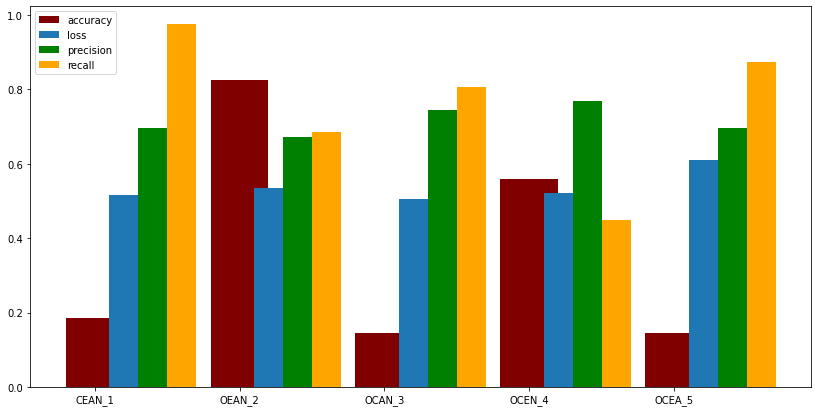

In [41]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(df1.index))
plt.bar(x_axis, df1["Accuracy"], color="maroon",label='accuracy',width=0.4) 
plt.bar(x_axis+0.2, df1["Loss"],label='loss',width=0.2 )
plt.bar(x_axis+0.4, df1["Precision"], color="green",label='precision',width=0.2)
plt.bar(x_axis+0.6, df1["Recall"], color="orange",label='recall',width=0.2)
plt.xticks(x_axis,df1.index)
plt.legend()


#relying primarly on the accuracy metric we can see that using OEAN_2 (droping conscientious) results in the best model